0) Setup (Colab) — installs and environment check

In [ ]:
# System OCR for pytesseract (reads banner text)
!apt-get -y install tesseract-ocr >/dev/null

# Core Python packages
!pip -q install opencv-python pillow pytesseract torch torchvision matplotlib pandas tqdm

import torch, platform
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
print("Python:", platform.python_version())


Torch: 2.8.0+cu126 | CUDA available: False
Python: 3.12.11


1) Inputs, output paths, and tuning knobs

In [ ]:
from pathlib import Path

# ======= USER INPUTS =======
VIDEO_PATH = Path("/content/video analysis location.mp4")  # <-- upload & set your filename

# Desired FPS for extraction (time-based seeking)
DESIRED_FPS      = 1.0

# Motion labeler sensitivity (area in pixels of motion blobs)
MIN_AREA         = 1000     # lower -> more boxes (noisier); higher -> fewer boxes (cleaner)

# Training knobs
EPOCHS           = 2
BATCH_SIZE       = 2
SKIP_ALL_EMPTY   = True      # skip batches where every image has zero labels
TRAIN_POSITIVES_ONLY = False # train only on images that have >=1 box

# Inference threshold
CONF_THRESH      = 0.30

# Reproducibility
RANDOM_SEED      = 42

# ======= FIXED GEOMETRY FOR YOUR SAMPLE =======
# From your sample frame: 848x448; banner is top ~53 px
W, H       = 848, 448
H_BANNER   = 53  # vertical pixels to ignore at top (banner)

# ======= OUTPUT FOLDERS =======
OUT_ROOT   = Path("/content/dataset_pipeline")
FRAMES_DIR = OUT_ROOT / "images"        # extracted frames
LABELS_DIR = OUT_ROOT / "labels"        # YOLO TXT labels
META_CSV   = OUT_ROOT / "metadata.csv"  # per-frame time + LAT/LON
for d in [OUT_ROOT, FRAMES_DIR, LABELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Video:", VIDEO_PATH)
print("Output root:", OUT_ROOT)


Video: /content/video analysis location.mp4
Output root: /content/dataset_pipeline


2) Utilities — OCR, YOLO conversions, banner clipping

In [ ]:
import cv2, re, numpy as np, pytesseract

def ocr_lat_lon_848x448(bgr_img):
    """
    OCR LAT/LON from the top banner (0..H_BANNER px) of a 848x448 frame.
    Returns strings (lat, lon) or ("","") if not found.
    """
    # Crop the banner region exactly (top H_BANNER px)
    band = bgr_img[0:H_BANNER, 0:W]
    gray = cv2.cvtColor(band, cv2.COLOR_BGR2GRAY)
    # Light denoise + adaptive binarization helps OCR robustness
    gray = cv2.bilateralFilter(gray, 5, 60, 60)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    text = pytesseract.image_to_string(th)

    # Patterns like: LAT: 19.046154 , LNG: 84.631935
    lat = lon = ""
    lat_m = re.search(r'LAT[:\s]+(-?\d+(?:\.\d+)?)', text, re.IGNORECASE)
    lon_m = re.search(r'(?:LON|LNG)[:\s]+(-?\d+(?:\.\d+)?)', text, re.IGNORECASE)
    if lat_m: lat = lat_m.group(1)
    if lon_m: lon = lon_m.group(1)
    return lat, lon

def xyxy_to_yolo(x1, y1, x2, y2, cls=0, w=W, h=H):
    """
    Convert pixel box (x1,y1,x2,y2) to YOLO normalized "cls cx cy w h".
    Normalization is fixed to W=848, H=448 (your sample).
    """
    bw = (x2 - x1) / w
    bh = (y2 - y1) / h
    cx = (x1 + x2) / 2 / w
    cy = (y1 + y2) / 2 / h
    return f"{int(cls)} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}"

def clip_below_banner(x1, y1, x2, y2, banner_y=H_BANNER):
    """
    Ensure boxes do not cover the banner area (0..banner_y).
    - Drop boxes fully inside the banner.
    - Clip boxes that cross into the banner so y1 >= banner_y.
    """
    if y2 <= banner_y:  # fully in banner
        return None
    y1c = max(y1, banner_y)  # clip top
    if x2 <= x1 or y2 <= y1c:
        return None
    return (x1, y1c, x2, y2)


In [ ]:
import cv2, pytesseract
from pathlib import Path

# Config: your frame size + banner height
W, H = 848, 448
H_BANNER = 60   # adjust if your banner is taller/shorter

def debug_ocr_banner(bgr_img, h_banner=H_BANNER):
    """
    Crop the top banner of the frame, run OCR, and print the raw text.
    """
    # Crop
    band = bgr_img[0:H_BANNER, 0:W]

    # Preprocess: grayscale + threshold for OCR clarity
    gray = cv2.cvtColor(band, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 5, 60, 60)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # OCR (raw text)
    text = pytesseract.image_to_string(th, config="--psm 6")

    print("==== RAW OCR TEXT FROM BANNER ====")
    print(text)
    print("==================================")

    return text

# Example usage on one saved frame
img = cv2.imread("/content/dataset_pipeline/images/sec_0000012000.jpg")  # put your frame path here
debug_ocr_banner(img)

==== RAW OCR TEXT FROM BANNER ====
Sayuhhte eet nae
on vent Y Pred we a
oe oacrne Oe rs pron)
ome 2 om ar Be
mE i pon mm rs



'Sayuhhte eet nae\non vent Y Pred we a\noe oacrne Oe rs pron)\nome 2 om ar Be\nmE i pon mm rs\n\x0c'

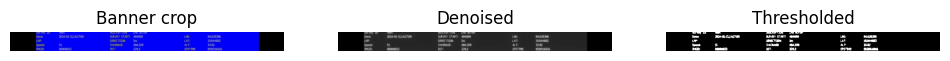

==== RAW OCR TEXT FROM BANNER ====
Sayuhhte eet nae
on vent Y Pred we a
oe oacrne Oe rs pron)
ome 2 om ar Be
mE i pon mm rs



'Sayuhhte eet nae\non vent Y Pred we a\noe oacrne Oe rs pron)\nome 2 om ar Be\nmE i pon mm rs\n\x0c'

In [ ]:
import cv2, pytesseract
import matplotlib.pyplot as plt

W, H = 848, 448
H_BANNER = 60

def debug_ocr_banner(bgr_img, h_banner=H_BANNER):
    if bgr_img is None:
        raise ValueError("Input image is None")

    # Resize if not already 848x448
    if bgr_img.shape[1] != W or bgr_img.shape[0] != H:
        bgr_img = cv2.resize(bgr_img, (W, H))

    # Crop banner
    band = bgr_img[0:h_banner, 0:W]

    # Preprocess steps
    gray = cv2.cvtColor(band, cv2.COLOR_BGR2GRAY)
    denoised = cv2.bilateralFilter(gray, 5, 60, 60)
    _, th = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # OCR
    text = pytesseract.image_to_string(th, config="--psm 6")

    # Show pipeline
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(band, cv2.COLOR_BGR2RGB)); plt.title("Banner crop"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(denoised, cmap="gray"); plt.title("Denoised"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(th, cmap="gray"); plt.title("Thresholded"); plt.axis("off")
    plt.show()

    print("==== RAW OCR TEXT FROM BANNER ====")
    print(text)
    print("==================================")

    return text

# Example usage
img = cv2.imread("/content/dataset_pipeline/images/sec_0000012000.jpg")
debug_ocr_banner(img)


3) Extract frames by time-based seeking + OCR GPS

In [ ]:
from datetime import timedelta
import pandas as pd
from tqdm import tqdm

def extract_frames_time_seek(video_path, out_dir, meta_csv, desired_fps=1.0):
    """
    Time-based seeking: jump to exact timestamps t = k*(1/desired_fps) seconds
    (works well for variable-FPS videos).
    Saves each frame and writes LAT/LON + timestamp to a CSV.
    """
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {video_path}")

    fps = cap.get(cv2.CAP_PROP_FPS) or 0.0
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    duration = frames / fps if fps > 0 else None

    rows = []
    t = 0.0
    interval = 1.0 / desired_fps
    total = int(duration * desired_fps) if duration else None

    with tqdm(total=total, desc="Extracting") as pbar:
        while duration is None or t <= duration:
            cap.set(cv2.CAP_PROP_POS_MSEC, t * 1000.0)
            ret, frame = cap.read()
            if not ret:
                break

            # Normalize size to 848x448 (if input differs)
            h, w = frame.shape[:2]
            if (w, h) != (W, H):
                frame = cv2.resize(frame, (W, H), interpolation=cv2.INTER_LINEAR)

            fname = f"sec_{int(round(t*1000)):010d}.jpg"  # unique by ms mark
            fpath = str(out_dir / fname)
            cv2.imwrite(fpath, frame)

            # OCR LAT/LON from the top banner
            lat, lon = ocr_lat_lon_848x448(frame)

            rows.append({
                "image": fname,
                "time_seconds": round(t, 3),
                "timecode": str(timedelta(seconds=float(t))),
                "lat": lat,
                "lon": lon
            })

            t += interval
            if total:
                pbar.update(1)

    cap.release()
    pd.DataFrame(rows).to_csv(meta_csv, index=False)
    print(f"Saved {len(rows)} frames → {out_dir}\nWrote metadata → {meta_csv}")

# Run extraction
extract_frames_time_seek(VIDEO_PATH, FRAMES_DIR, META_CSV, DESIRED_FPS)


Extracting: 100%|██████████| 471/471 [01:56<00:00,  4.05it/s]

Saved 471 frames → /content/dataset_pipeline/images
Wrote metadata → /content/dataset_pipeline/metadata.csv


4) Auto-label motion (single class) below banner

In [ ]:
import glob

def autolabel_motion(frames_dir, labels_dir, min_area=MIN_AREA):
    """
    Simple auto-labeler based on inter-frame motion.
    - Compares each frame to the previous one.
    - Finds motion blobs (contours) and writes YOLO labels for class 0 'object'.
    - Ignores/clips any box that falls into the top banner region.
    """
    frames_dir, labels_dir = Path(frames_dir), Path(labels_dir)
    labels_dir.mkdir(parents=True, exist_ok=True)

    paths = sorted(glob.glob(str(frames_dir / "*.jpg")))
    prev_gray = None
    wrote = 0

    for p in tqdm(paths, desc="Auto-label"):
        img = cv2.imread(p)
        if img is None:
            continue

        # Force 848x448 so normalization remains consistent
        h, w = img.shape[:2]
        if (w, h) != (W, H):
            img = cv2.resize(img, (W, H), interpolation=cv2.INTER_LINEAR)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        yolo_lines = []

        if prev_gray is not None and prev_gray.shape == gray.shape:
            diff = cv2.absdiff(gray, prev_gray)
            blur = cv2.GaussianBlur(diff, (5,5), 0)
            _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            th = cv2.dilate(th, None, iterations=2)
            contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for c in contours:
                if cv2.contourArea(c) < min_area:
                    continue
                x, y, ww, hh = cv2.boundingRect(c)
                clipped = clip_below_banner(x, y, x + ww, y + hh, H_BANNER)
                if clipped is None:
                    continue
                x1, y1, x2, y2 = clipped
                yolo_lines.append(xyxy_to_yolo(x1, y1, x2, y2, cls=0))  # class 0: object

        prev_gray = gray

        # Write YOLO txt (may be empty if no motion)
        (labels_dir / (Path(p).stem + ".txt")).write_text("\n".join(yolo_lines))
        if yolo_lines:
            wrote += 1

    print(f"Auto-labeled {wrote}/{len(paths)} frames (min_area={min_area}).")

# Run auto-labeler
autolabel_motion(FRAMES_DIR, LABELS_DIR, min_area=MIN_AREA)


Auto-label: 100%|██████████| 471/471 [00:02<00:00, 192.65it/s]

Auto-labeled 470/471 frames (min_area=1000).


5) Train/Val split (option to use positives-only)

In [ ]:
import random, shutil

random.seed(RANDOM_SEED)

def has_label(img_path, labels_dir):
    lp = Path(labels_dir) / (Path(img_path).stem + ".txt")
    return lp.exists() and lp.read_text().strip() != ""

def copy_pair(img_path, src_labels_dir, dst_img_dir, dst_lbl_dir):
    ip = Path(img_path)
    lp = Path(src_labels_dir) / (ip.stem + ".txt")
    dst_img = Path(dst_img_dir) / ip.name
    dst_lbl = Path(dst_lbl_dir) / lp.name
    shutil.copy2(ip, dst_img)
    if lp.exists():
        shutil.copy2(lp, dst_lbl)
    else:
        dst_lbl.write_text("")

def make_split(images_dir, labels_dir, out_root, train_ratio=0.8, positives_only=TRAIN_POSITIVES_ONLY):
    images_dir, labels_dir = Path(images_dir), Path(labels_dir)
    IMAGES_TRAIN = out_root / "images_train"
    IMAGES_VAL   = out_root / "images_val"
    LABELS_TRAIN = out_root / "labels_train"
    LABELS_VAL   = out_root / "labels_val"
    for d in [IMAGES_TRAIN, IMAGES_VAL, LABELS_TRAIN, LABELS_VAL]:
        d.mkdir(exist_ok=True)

    all_imgs = sorted(glob.glob(str(images_dir / "*.jpg")))
    if positives_only:
        all_imgs = [p for p in all_imgs if has_label(p, labels_dir)]
        print(f"Using positives only: {len(all_imgs)} images")

    random.shuffle(all_imgs)
    split = int(train_ratio * len(all_imgs))
    train_imgs, val_imgs = all_imgs[:split], all_imgs[split:]

    for p in train_imgs: copy_pair(p, labels_dir, IMAGES_TRAIN, LABELS_TRAIN)
    for p in val_imgs:   copy_pair(p, labels_dir, IMAGES_VAL,   LABELS_VAL)

    return IMAGES_TRAIN, IMAGES_VAL, LABELS_TRAIN, LABELS_VAL

IMAGES_TRAIN, IMAGES_VAL, LABELS_TRAIN, LABELS_VAL = make_split(
    FRAMES_DIR, LABELS_DIR, OUT_ROOT, train_ratio=0.8, positives_only=TRAIN_POSITIVES_ONLY
)

print("Train:", len(list(IMAGES_TRAIN.glob('*.jpg'))),
      "| Val:", len(list(IMAGES_VAL.glob('*.jpg'))))


Train: 376 | Val: 95


6) PyTorch Dataset (YOLO TXT → Faster R-CNN) — with empty-box fix

In [ ]:
from PIL import Image
import torch
import torch.utils.data as data
from torchvision import transforms

class YoloTxtDetectionDataset(data.Dataset):
    """
    Reads images + YOLO txt labels → returns tensors suitable for Faster R-CNN.
    Ensures empty label cases produce target['boxes'] with shape [0,4].
    """
    def __init__(self, images_dir, labels_dir, tf=None):
        self.images = sorted(glob.glob(str(Path(images_dir) / "*.jpg")))
        self.labels_dir = Path(labels_dir)
        self.tf = tf or transforms.ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        im = Image.open(img_path).convert("RGB")
        w, h = im.size  # expect 848x448 after our resizing

        txt_path = self.labels_dir / (Path(img_path).stem + ".txt")
        boxes_list, labels_list = [], []

        if txt_path.exists():
            for line in txt_path.read_text().splitlines():
                line = line.strip()
                if not line:
                    continue
                cls_str, cx_str, cy_str, bw_str, bh_str = line.split()
                cls = int(cls_str)
                cx, cy, bw, bh = map(float, (cx_str, cy_str, bw_str, bh_str))
                x1 = (cx - bw/2) * w; y1 = (cy - bh/2) * h
                x2 = (cx + bw/2) * w; y2 = (cy + bh/2) * h
                if x2 <= x1 or y2 <= y1:   # guard against degenerate boxes
                    continue
                boxes_list.append([x1, y1, x2, y2])
                labels_list.append(cls + 1)  # torchvision background=0, so our class 0 → label 1

        # ***** Critical: keep empty tensors with correct shape *****
        if boxes_list:
            boxes  = torch.as_tensor(boxes_list, dtype=torch.float32)  # [N,4]
            labels = torch.as_tensor(labels_list, dtype=torch.int64)   # [N]
        else:
            boxes  = torch.zeros((0, 4), dtype=torch.float32)          # [0,4] ✅
            labels = torch.zeros((0,), dtype=torch.int64)              # [0]   ✅

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}
        im = self.tf(im)
        return im, target

def collate_fn(batch):
    imgs, targets = list(zip(*batch))
    return list(imgs), list(targets)

tfm = transforms.ToTensor()
train_ds = YoloTxtDetectionDataset(IMAGES_TRAIN, LABELS_TRAIN, tf=tfm)
val_ds   = YoloTxtDetectionDataset(IMAGES_VAL,   LABELS_VAL,   tf=tfm)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn)

print("Batches -> train:", len(train_loader), "val:", len(val_loader))


Batches -> train: 188 val: 48


7) Model & Training (Faster R-CNN) — skip all-empty batches option

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes=2):  # background + object
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(2).to(device)

optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad],
                            lr=0.005, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def train_one_epoch(model, loader, optimizer, device, skip_all_empty=SKIP_ALL_EMPTY):
    """
    One epoch of Faster R-CNN training. If skip_all_empty=True,
    we skip batches where every image has zero boxes (nothing to learn).
    """
    model.train()
    running, steps = 0.0, 0
    from tqdm import tqdm
    for imgs, targets in tqdm(loader, leave=False):
        if skip_all_empty and all(t["boxes"].shape[0] == 0 for t in targets):
            continue

        imgs = [im.to(device) for im in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += float(loss.item())
        steps += 1

    return running / max(1, steps)

for ep in range(EPOCHS):
    tl = train_one_epoch(model, train_loader, optimizer, device, skip_all_empty=SKIP_ALL_EMPTY)
    scheduler.step()
    print(f"Epoch {ep+1}/{EPOCHS} | train loss: {tl:.4f}")

WEIGHTS = OUT_ROOT / "fasterrcnn_object.pth"
torch.save(model.state_dict(), WEIGHTS)
print("Saved weights →", WEIGHTS)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:01<00:00, 143MB/s]


Epoch 1/2 | train loss: 0.6990


Epoch 2/2 | train loss: 0.6858
Saved weights → /content/dataset_pipeline/fasterrcnn_object.pth


8) Inference + GPS/time join → CSV

In [ ]:
import pandas as pd, glob
from torchvision import transforms
from PIL import Image

# Reload model for inference (safe in fresh sessions)
model = get_model(2).to(device)
model.load_state_dict(torch.load(WEIGHTS, map_location=device))
model.eval()

# Load metadata (time + LAT/LON) produced at extraction time
meta_df = pd.read_csv(META_CSV)
meta_map = {row["image"]: row for _, row in meta_df.iterrows()}

tfm = transforms.ToTensor()
results = []

with torch.no_grad():
    # Here we infer on the validation set; you can switch to IMAGES_TRAIN or FRAMES_DIR
    for img_path in sorted(glob.glob(str(IMAGES_VAL / "*.jpg"))):
        name = Path(img_path).name
        im = tfm(Image.open(img_path).convert("RGB")).to(device)
        out = model([im])[0]

        boxes  = out["boxes"].detach().cpu().numpy()
        scores = out["scores"].detach().cpu().numpy()
        labels = out["labels"].detach().cpu().numpy()  # 1 = object

        meta = meta_map.get(name, {})
        lat   = meta.get("lat", "")
        lon   = meta.get("lon", "")
        tsec  = meta.get("time_seconds", "")
        tcode = meta.get("timecode", "")

        for (x1,y1,x2,y2), sc, lb in zip(boxes, scores, labels):
            if sc < CONF_THRESH:
                continue
            results.append({
                "image": name,
                "time_seconds": tsec,
                "timecode": tcode,
                "lat": lat,
                "lon": lon,
                "class": int(lb - 1),  # back to 0-based for user (0=object)
                "score": float(sc),
                "x1": float(x1), "y1": float(y1), "x2": float(x2), "y2": float(y2),
            })

det_csv = OUT_ROOT / "detections_with_gps.csv"
pd.DataFrame(results).to_csv(det_csv, index=False)
print("Wrote detections →", det_csv, "| rows:", len(results))


Wrote detections → /content/dataset_pipeline/detections_with_gps.csv | rows: 1506


9) (Optional) Visualize detections + GPS text on images

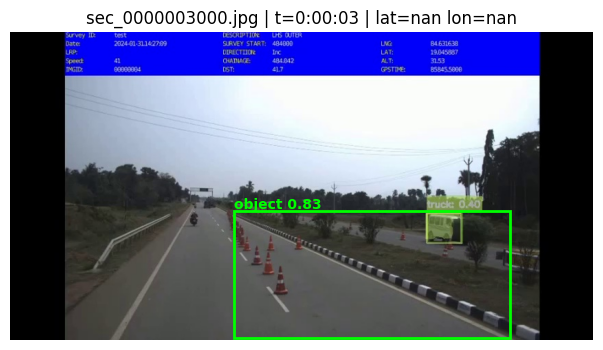

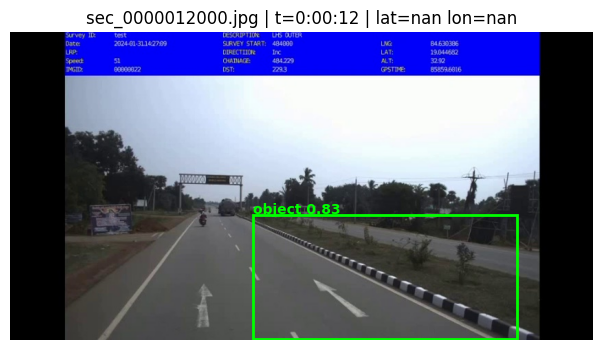

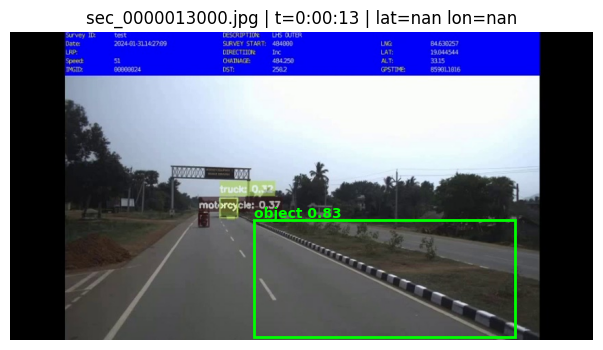

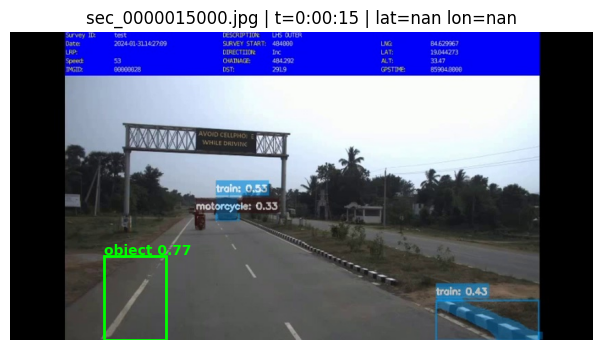

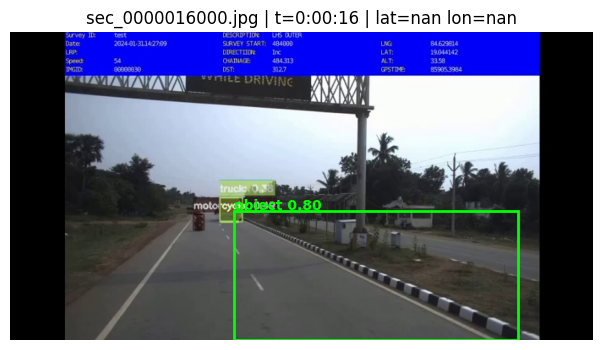

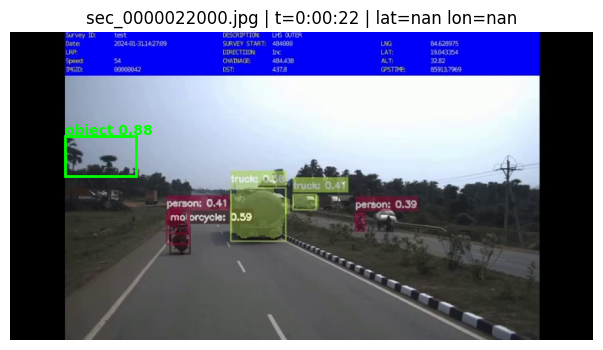

Saved visualization frames → /content/dataset_pipeline/viz_val


In [ ]:
import matplotlib.pyplot as plt

DRAW_DIR = OUT_ROOT / "viz_val"
DRAW_DIR.mkdir(exist_ok=True)

def draw_box(ax, box, color="lime", lw=2, label=None):
    x1, y1, x2, y2 = box
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, lw=lw, color=color)
    ax.add_patch(rect)
    if label:
        ax.text(x1, max(0, y1-3), label, color=color, fontsize=10, weight="bold")

# Display a few samples (one detection per image, up to 6 images)
import pandas as pd
df = pd.read_csv(det_csv)
sample = df.groupby("image").head(1).head(6)

for _, row in sample.iterrows():
    img_path = IMAGES_VAL / row["image"]
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=(8,4))
    ax.imshow(img); ax.axis("off")
    ttl = f"{row['image']} | t={row['timecode']} | lat={row['lat']} lon={row['lon']}"
    ax.set_title(ttl)
    draw_box(ax, (row["x1"],row["y1"],row["x2"],row["y2"]),
             label=f"object {row['score']:.2f}")
    outp = DRAW_DIR / row["image"]
    plt.savefig(outp, bbox_inches="tight")
    plt.show()

print("Saved visualization frames →", DRAW_DIR)
